原圖(495x411)：


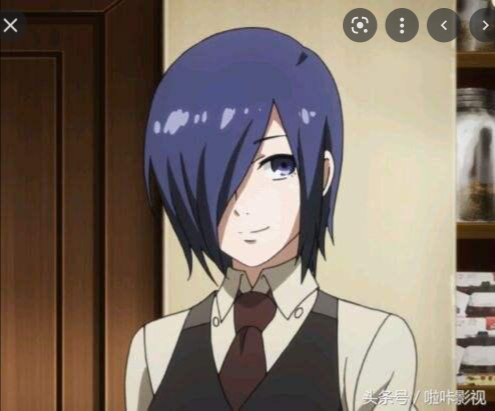

縮放後65x53：


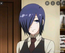

色彩量化：


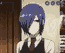

In [30]:
from PIL import Image, ImageFilter
from IPython.display import display
import numpy as np
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from selenium.webdriver.common.action_chains import ActionChains

# 可用顏色
colors = [
    (0, 0, 0),
    (102, 102, 102),
    (0, 23, 246),
    (255, 255, 255),
    (170, 170, 170),
    (38, 201, 255),
    (0, 141, 38),
    (169, 35, 12),
    (150, 65, 18),
    (0, 255, 77),
    (255, 0, 19),
    (255, 120, 41),
    (176, 112, 28),
    (153, 0, 78),
    (147, 104, 103),
    (255, 201, 38),
    (255, 0, 143),
    (254, 175, 168),
    # (0, 217, 163),
    # (133, 178, 0),
    # (128, 0, 255),
    # (5, 44, 108),
    # (185, 115, 255),
    # (255, 247, 63),
]


def color_diff(rgb1, rgb2):
    """計算CIE2000色差"""
    color1_rgb = sRGBColor(*rgb1, is_upscaled=True)
    color2_rgb = sRGBColor(*rgb2, is_upscaled=True)
    color1_lab = convert_color(color1_rgb, LabColor)
    color2_lab = convert_color(color2_rgb, LabColor)
    delta_e = delta_e_cie2000(color1_lab, color2_lab)
    return delta_e


def resize_based_on_width(im, basewidth=65):
    """以basewidth為基準，縮放圖片"""
    wpercent = basewidth / float(im.size[0])
    hsize = int((float(im.size[1]) * float(wpercent)))
    im = im.resize((basewidth, hsize), Image.Resampling.LANCZOS)
    return im


def preprocess(im):
    """預處理圖片"""
    print(f"原圖({im.size[0]}x{im.size[1]})：")
    display(im)
    im = resize_based_on_width(im)
    print(f"縮放後{im.size[0]}x{im.size[1]}：")
    display(im)
    # im = im.filter(ImageFilter.GaussianBlur(0.7))
    # print('模糊後')
    # display(im)
    print("色彩量化：")
    im = im.quantize(24)
    display(im)
    im = im.convert("RGB")
    a = np.asarray(im)
    return a


color_id_map = {}


def make_line(a):
    """1 image row to line"""
    line = []
    head = None
    for i in range(len(a) - 1):
        if i == 0:
            head = i
        else:
            if (a[i] != a[i + 1]).all():
                tail = i

                min_color_id = None
                if tuple(a[i]) not in color_id_map:
                    for j in range(len(colors)):
                        delta = color_diff(a[i], colors[j])
                        if min_color_id is None:
                            min_color_id = j
                            min_delta = delta
                        else:
                            if delta < min_delta:
                                min_color_id = j
                                min_delta = delta
                    color_id_map[tuple(a[i])] = min_color_id
                else:
                    min_color_id = color_id_map[tuple(a[i])]

                if min_color_id != 3:  # white
                    line += [[head, tail, min_color_id]]
                # next
                head = i + 1
    return line


def make_lines(a):
    """image to lines"""
    lines = []
    for a_ in a:
        lines += [make_line(a_)]
    return lines


def draw(driver, elem, lines, xoffset=10, yoffset=10, gap=1, line_height=None):
    color_elem_map = {}
    for i in range(len(colors)):
        color_elem_map[i] = driver.find_element(
            By.XPATH,
            f"/html/body/div[2]/div/div[2]/div[1]/div/div/div[1]/div[2]/div/div[2]/div[1]/div[{i+1}]",
        )
    if line_height is None:
        line_height = gap

    action = ActionChains(driver)
    action.w3c_actions.pointer_action._duration = 1
    for i, line in enumerate(lines):
        for seg in line:
            action.click(color_elem_map[seg[2]])
            action.move_to_element_with_offset(
                elem, xoffset + seg[0] * gap, yoffset + i * line_height
            )
            if seg[0] == seg[1]:
                action.click()
            else:
                action.click_and_hold()
                action.move_to_element_with_offset(
                    elem, xoffset + seg[1] * gap, yoffset + i * line_height
                )
                action.release()
        try:
            action.perform()
        except Exception as e:
            print(e)
            pass

def draw_by_color(driver, elem, lines, xoffset=10, yoffset=10, gap=1, line_height=None):
    color_elem_map = {}
    for i in range(len(colors)):
        color_elem_map[i] = driver.find_element(
            By.XPATH,
            f"/html/body/div[2]/div/div[2]/div[1]/div/div/div[1]/div[2]/div/div[2]/div[1]/div[{i+1}]",
        )
    if line_height is None:
        line_height = gap
    
    color_map = {}
    for height, line in enumerate(lines):
        for seg in line:
            seg += [height]
            if seg[2] not in color_map:
                color_map[seg[2]] = [seg]
            else:
                color_map[seg[2]] += [seg]
    
    action = ActionChains(driver)
    action.w3c_actions.pointer_action._duration = 1
    for color, color_line in color_map.items():
        action.click(color_elem_map[color])
        for i, seg in enumerate(color_line):
            action.move_to_element_with_offset(
                elem, xoffset + seg[0] * gap, yoffset + seg[3] * line_height
            )
            if seg[0] == seg[1]:
                action.click()
            else:
                action.click_and_hold()
                action.move_to_element_with_offset(
                    elem, xoffset + seg[1] * gap, yoffset + seg[3] * line_height
                )
                action.release()
            try:
                action.perform()
            except Exception as e:
                print(e)
                pass


im = Image.open("image.jpg")
preprocess(im)
print()


In [34]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

options = Options()
options.add_extension("uBlock-Origin.crx")
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
driver.get("https://gartic.io/")

print("Chrome Browser Invoked")


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [C:\Users\Asus\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache
C:\Users\Asus\AppData\Local\Temp\ipykernel_12196\611495026.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


Chrome Browser Invoked


In [31]:
# 找出題目
driver.switch_to.window(driver.window_handles[0])
soup = BeautifulSoup(driver.page_source, "html.parser")
titles = soup.find_all("div", class_="word")
if titles:
    keyword = titles[0].text
    for i in range(1, len(titles)):
        keyword += " " + titles[i].text
    print("題目：" + keyword)

# keyword = ""
suffix = ""
if suffix != "":
    query = keyword + "+" + suffix
else:
    query = keyword
script = (
    f"window.open('https://www.google.com/search?q={query}&tbm=isch&hl=zh-TW');"
)
driver.execute_script(script)

題目：魯邦三世


儲存圖片(image.jpg)：


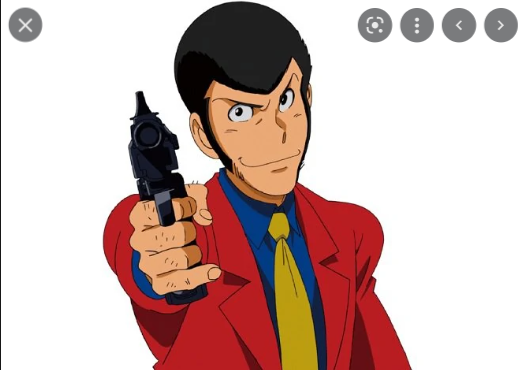

In [32]:
# 儲存圖片
driver.switch_to.window(driver.window_handles[1])
img = driver.find_element(By.XPATH, '/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[3]/div/a/img')
img.screenshot('image.jpg')
print('儲存圖片(image.jpg)：')
display(Image.open('image.jpg'))

原圖(525x370)：


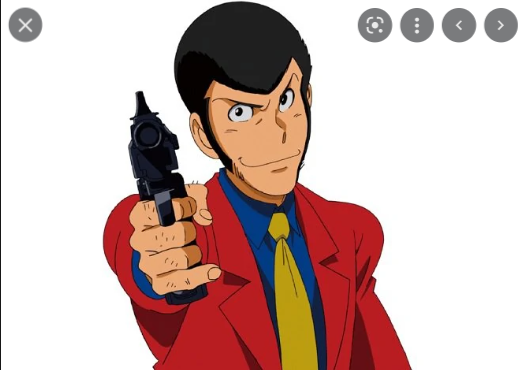

縮放後65x45：


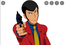

色彩量化：


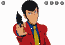

KeyboardInterrupt: 

In [36]:
# 畫畫
if len(driver.window_handles) > 1:
    driver.close()
driver.switch_to.window(driver.window_handles[0])

wait = WebDriverWait(driver, 999999, 0.5)
element = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "hint")))
wait = WebDriverWait(driver, 999999, 0.5)
elem = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "canvas")))

with Image.open("image.jpg") as im:
    if elem:
        a = preprocess(im)
        lines = make_lines(a)
        draw_by_color(driver=driver, elem=elem, lines=lines, gap=2.5, xoffset=100, yoffset=50)